In [1]:
#


--- Model 1: Problem 1 ---
Epoch 00000: Loss = 9.597028e-01, LR = 1.000e-03
Epoch 00500: Loss = 3.420920e-03, LR = 1.000e-03
Epoch 01000: Loss = 2.785385e-03, LR = 1.000e-03
Epoch 01500: Loss = 7.310853e-04, LR = 1.000e-03
Epoch 02000: Loss = 4.639015e-04, LR = 1.000e-03
Epoch 02500: Loss = 5.780767e-04, LR = 1.000e-03
Epoch 03000: Loss = 2.590126e-04, LR = 1.000e-03
Epoch 03500: Loss = 2.013299e-04, LR = 1.000e-03
Epoch 04000: Loss = 1.909811e-04, LR = 1.000e-03
Epoch 04500: Loss = 1.365712e-04, LR = 1.000e-03
Epoch 05000: Loss = 1.162278e-04, LR = 1.000e-04
Epoch 05500: Loss = 1.070504e-04, LR = 1.000e-04
Epoch 06000: Loss = 1.009445e-04, LR = 1.000e-04
Epoch 06500: Loss = 9.473575e-05, LR = 1.000e-04
Epoch 07000: Loss = 8.834823e-05, LR = 1.000e-04
Epoch 07500: Loss = 8.174856e-05, LR = 1.000e-04
Epoch 08000: Loss = 7.496092e-05, LR = 1.000e-04
Epoch 08500: Loss = 6.805480e-05, LR = 1.000e-04
Epoch 09000: Loss = 6.110348e-05, LR = 1.000e-04
Epoch 09500: Loss = 5.622968e-05, LR = 1.

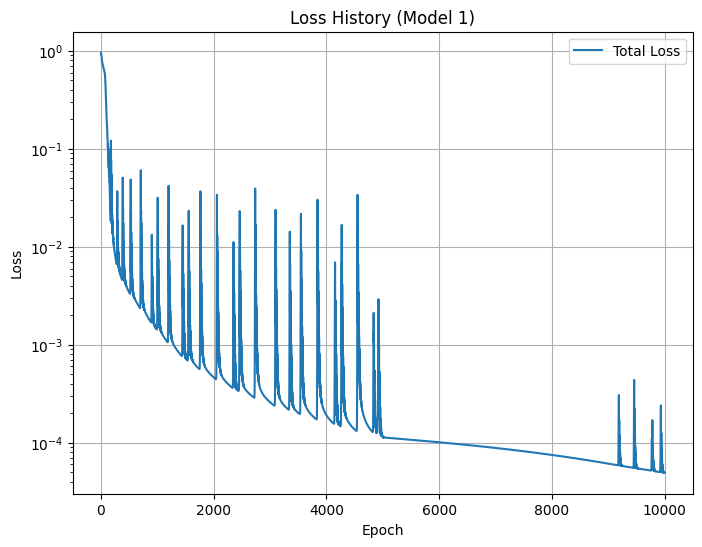

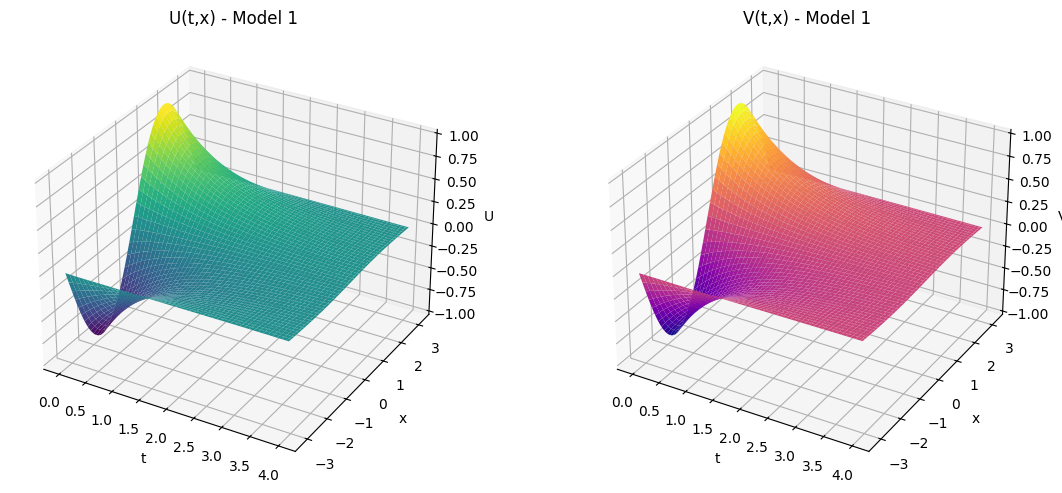

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Device and dtype
DTYPE = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Problem 1 Setup ---
print("\n--- Model 1: Problem 1 ---")

# Domain bounds for Problem 1
pi_1 = torch.tensor(np.pi, dtype=DTYPE, device=device)
tmin_1, tmax_1 = 0., 4.
xmin_1, xmax_1 = -np.pi, np.pi
lb_1 = torch.tensor([tmin_1, xmin_1], dtype=DTYPE, device=device)
ub_1 = torch.tensor([tmax_1, xmax_1], dtype=DTYPE, device=device)

# Initial conditions for Problem 1
def fun_u_0_1(x):
    """Initial condition for u(x, 0) in Problem 1."""
    return torch.sin(x)

def fun_v_0_1(x):
    """Initial condition for v(x, 0) in Problem 1."""
    return torch.sin(x)

# Boundary conditions (periodic - implemented as data) for Problem 1
def fun_u_b_1(t, x):
    """Boundary condition for u(t, x) in Problem 1.  Returns 0 for periodic."""
    return torch.zeros_like(x)

def fun_v_b_1(t, x):
    """Boundary condition for v(t, x) in Problem 1.  Returns 0 for periodic."""
    return torch.zeros_like(x)

# Sample sizes for Problem 1
N_0_1, N_b_1, N_r_1 = 100, 200, 5000  # Number of points for initial, boundary, and residual

# Initial points for Problem 1
t_0_1 = torch.full((N_0_1, 1), lb_1[0], device=device)  # t = 0
x_0_1 = (ub_1[1] - lb_1[1]) * torch.rand((N_0_1, 1), device=device) + lb_1[1]  # Random x in domain
X_0_1 = torch.cat([t_0_1, x_0_1], dim=1)  # Combine t and x
u_0_1 = fun_u_0_1(x_0_1)  # Initial u values
v_0_1 = fun_v_0_1(x_0_1)  # Initial v values

# Boundary points for Problem 1
t_b_1 = (ub_1[0] - lb_1[0]) * torch.rand((N_b_1, 1), device=device)  # Random t
x_b_1 = torch.bernoulli(torch.full((N_b_1, 1), 0.5, device=device)) * (
            ub_1[1] - lb_1[1]) + lb_1[1]  # x = xmin or xmax
X_b_1 = torch.cat([t_b_1, x_b_1], dim=1)  # Combine t and x
u_b_1 = fun_u_b_1(t_b_1, x_b_1)  # Boundary u values (all 0 in this case)
v_b_1 = fun_v_b_1(t_b_1, x_b_1)  # Boundary v values (all 0 in this case)

# Collocation (residual) points for Problem 1
t_r_1 = (ub_1[0] - lb_1[0]) * torch.rand((N_r_1, 1), device=device)  # Random t
x_r_1 = (ub_1[1] - lb_1[1]) * torch.rand((N_r_1, 1), device=device) + lb_1[1]  # Random x
X_r_1 = torch.cat([t_r_1, x_r_1], dim=1)  # Combine t and x

# Data for Problem 1
X_data_1 = [X_0_1, X_b_1]  # Combine initial and boundary points
u_data_1 = [u_0_1, u_b_1]  # Combine initial and boundary u values
v_data_1 = [v_0_1, v_b_1]  # Combine initial and boundary v values


# --- Coupled PINN Model for Problem 1 ---
class CoupledPINN_1(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=32):
        """
        Neural network model for Problem 1.

        Args:
            num_hidden_layers (int): Number of hidden layers.
            num_neurons_per_layer (int): Number of neurons in each hidden layer.
        """
        super(CoupledPINN_1, self).__init__()
        # Input scaling
        self.scaling = lambda x: 2.0 * (x - lb_1) / (ub_1 - lb_1) - 1.0

        def build_network():
            """Builds the neural network architecture."""
            layers = [nn.Linear(2, num_neurons_per_layer)]  # Input layer (t, x)
            for _ in range(num_hidden_layers):
                layers += [nn.Tanh(),
                           nn.Linear(num_neurons_per_layer,
                                     num_neurons_per_layer)]  # Hidden layers
            layers += [nn.Linear(num_neurons_per_layer,
                                 1)]  # Output layer (u or v)
            return nn.Sequential(*layers)

        self.net_u = build_network()  # Network for u(t, x)
        self.net_v = build_network()  # Network for v(t, x)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor (t, x).

        Returns:
            tuple: (u(t, x), v(t, x)).
        """
        x_scaled = self.scaling(x)  # Scale input
        return self.net_u(x_scaled), self.net_v(
            x_scaled)  # Get u and v predictions


# --- PDE Residuals for Problem 1 ---
def compute_residuals_1(model, X_r):
    """
    Computes the residuals of the PDE for Problem 1.

    Args:
        model (nn.Module): The neural network model.
        X_r (torch.Tensor): Collocation points (t, x).

    Returns:
        tuple: (r1, r2), the residuals for the two PDEs.
    """
    X_r.requires_grad_(True)  # Enable gradients for autograd
    t = X_r[:, 0:1]  # Extract t
    x = X_r[:, 1:2]  # Extract x

    u, v = model(X_r)  # Get u and v predictions

    # Compute gradients
    grads_u = \
    torch.autograd.grad(u, X_r, grad_outputs=torch.ones_like(u),
                           create_graph=True)[
        0]  # Get du/dt, du/dx
    grads_v = \
    torch.autograd.grad(v, X_r, grad_outputs=torch.ones_like(v),
                           create_graph=True)[
        0]  # Get dv/dt, dv/dx

    u_t, u_x = grads_u[:, 0:1], grads_u[:, 1:2]  # Extract du/dt, du/dx
    v_t, v_x = grads_v[:, 0:1], grads_v[:, 1:2]  # Extract dv/dt, dv/dx

    # Compute second derivatives
    u_xx = \
    torch.autograd.grad(u_x, X_r, grad_outputs=torch.ones_like(u_x),
                           create_graph=True)[0][
        :, 1:2]  # Get d^2u/dx^2
    v_xx = \
    torch.autograd.grad(v_x, X_r, grad_outputs=torch.ones_like(v_x),
                           create_graph=True)[0][
        :, 1:2]  # Get d^2v/dx^2

    uv = u * v  # Compute product of u and v
    uv_x = \
    torch.autograd.grad(uv, X_r, grad_outputs=torch.ones_like(uv),
                           create_graph=True)[0][
        :, 1:2]  # Get d(uv)/dx

    # Define the PDE residuals
    r1 = u_t - u_xx - 2 * u * u_x + uv_x
    r2 = v_t - v_xx - 2 * v * v_x + uv_x
    return r1, r2


# --- Loss Function for Problem 1 ---
def compute_loss_1(model, X_r, X_data, u_data, v_data):
    """
    Computes the loss for Problem 1.

    Args:
        model (nn.Module): The neural network model.
        X_r (torch.Tensor): Collocation points.
        X_data (list): List of data points [X_0, X_b].
        u_data (list): List of u values [u_0, u_b].
        v_data (list): List of v values [v_0, v_b].

    Returns:
        torch.Tensor: The total loss.
    """
    r1, r2 = compute_residuals_1(model,
                                   X_r)  # Compute PDE residuals at collocation points
    loss_r = torch.mean(
        r1 ** 2) + torch.mean(r2 ** 2)  # MSE of residuals
    loss_data = torch.tensor(0.0, dtype=DTYPE,
                               device=device)  # Initialize data loss
    for i in range(len(X_data)):
        u_pred, v_pred = model(
            X_data[i])  # Get predictions at data points
        loss_data += torch.mean(
            (u_data[i] - u_pred) ** 2)  # MSE of u at data points
        loss_data += torch.mean(
            (v_data[i] - v_pred) ** 2)  # MSE of v at data points
    return loss_r + loss_data  # Total loss


# --- Model, Optimizer, and Training for Problem 1 ---
model_1 = CoupledPINN_1().to(device)  # Instantiate the model
optimizer_1 = optim.Adam(model_1.parameters(),
                           lr=1e-3)  # Adam optimizer
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1,
                                                 step_size=5000,
                                                 gamma=0.1)  # Learning rate scheduler

# Training loop
epochs_1 = 10000  # Number of training epochs
loss_history_1 = []  # List to store loss history

start_time_1 = time()  # Start time
for epoch in range(epochs_1 + 1):
    optimizer_1.zero_grad()  # Zero gradients
    loss = compute_loss_1(model_1, X_r_1, X_data_1, u_data_1,
                             v_data_1)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer_1.step()  # Update weights
    scheduler_1.step()  # Update learning rate
    loss_history_1.append(loss.item())  # Store loss

    if epoch % 500 == 0:  # Print loss every 500 epochs
        print(
            f"Epoch {epoch:05d}: Loss = {loss.item():.6e}, LR = {optimizer_1.param_groups[0]['lr']:.3e}")

print("Training time (Model 1):",
      time() - start_time_1)  # Print total training time

# Plot loss history
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(loss_history_1)), loss_history_1,
         label='Total Loss')  # Plot the loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History (Model 1)')
plt.yscale('log')  # Use a logarithmic scale for the y-axis
plt.legend()
plt.grid(True)
plt.show()


# --- Define grid for plotting the solution ---
N_plot_1 = 100  # Number of points for plotting
t_vals_1 = torch.linspace(tmin_1, tmax_1, N_plot_1,
                            device=device)  # Time values
x_vals_1 = torch.linspace(xmin_1, xmax_1, N_plot_1,
                            device=device)  # Space values
T_1, X_1 = torch.meshgrid(t_vals_1, x_vals_1,
                            indexing='ij')  # Create a grid
TX_1 = torch.cat([T_1.reshape(-1, 1), X_1.reshape(-1, 1)],
                   dim=1)  # Combine t and x for input to the model

# --- Recompute the prediction on the grid ---
with torch.no_grad():  # Disable gradient calculation for inference
    prediction_1 = model_1(
        TX_1)  # Get predictions for u and v on the grid
    u_pred_1, v_pred_1 = prediction_1[0], prediction_1[
        1]  # Separate u and v predictions
    U_1 = u_pred_1.reshape(N_plot_1, N_plot_1).cpu().numpy()  # Reshape u for plotting
    V_1 = v_pred_1.reshape(N_plot_1, N_plot_1).cpu().numpy()  # Reshape v for plotting

T_np_1 = T_1.cpu().numpy()  # Convert t to numpy for plotting
X_np_1 = X_1.cpu().numpy()  # Convert x to numpy for plotting

# --- Plot the solution ---
fig_1 = plt.figure(figsize=(12, 5))  # Create a figure
ax1_1 = fig_1.add_subplot(121,
                             projection='3d')  # Add a 3D subplot for u
ax1_1.plot_surface(T_np_1, X_np_1, U_1,
                     cmap='viridis')  # Plot the surface for u
ax1_1.set_title("U(t,x) - Model 1")
ax1_1.set_xlabel('t')
ax1_1.set_ylabel('x')
ax1_1.set_zlabel('U')

ax2_1 = fig_1.add_subplot(122,
                             projection='3d')  # Add a 3D subplot for v
ax2_1.plot_surface(T_np_1, X_np_1, V_1,
                     cmap='plasma')  # Plot the surface for v
ax2_1.set_title("V(t,x) - Model 1")
ax2_1.set_xlabel('t')
ax2_1.set_ylabel('x')
ax2_1.set_zlabel('V')

plt.tight_layout()
plt.show()



--- Model 2: Problem 2 ---
Epoch 00000: Loss = 6.104097e-02, LR = 1.000e-03
Epoch 00500: Loss = 9.897084e-08, LR = 1.000e-03
Epoch 01000: Loss = 6.926233e-08, LR = 1.000e-03
Epoch 01500: Loss = 4.800858e-08, LR = 1.000e-03
Epoch 02000: Loss = 3.250317e-08, LR = 1.000e-03
Epoch 02500: Loss = 2.154339e-08, LR = 1.000e-03
Epoch 03000: Loss = 1.433249e-08, LR = 1.000e-03
Epoch 03500: Loss = 1.013116e-08, LR = 1.000e-03
Epoch 04000: Loss = 7.835481e-09, LR = 1.000e-03
Epoch 04500: Loss = 6.319567e-09, LR = 1.000e-03
Epoch 05000: Loss = 4.434706e-08, LR = 1.000e-04
Training time (Model 2): 151.17939496040344


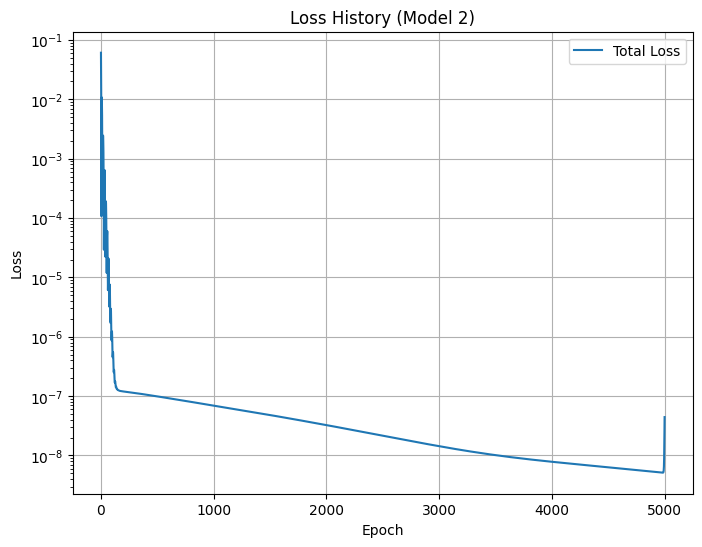

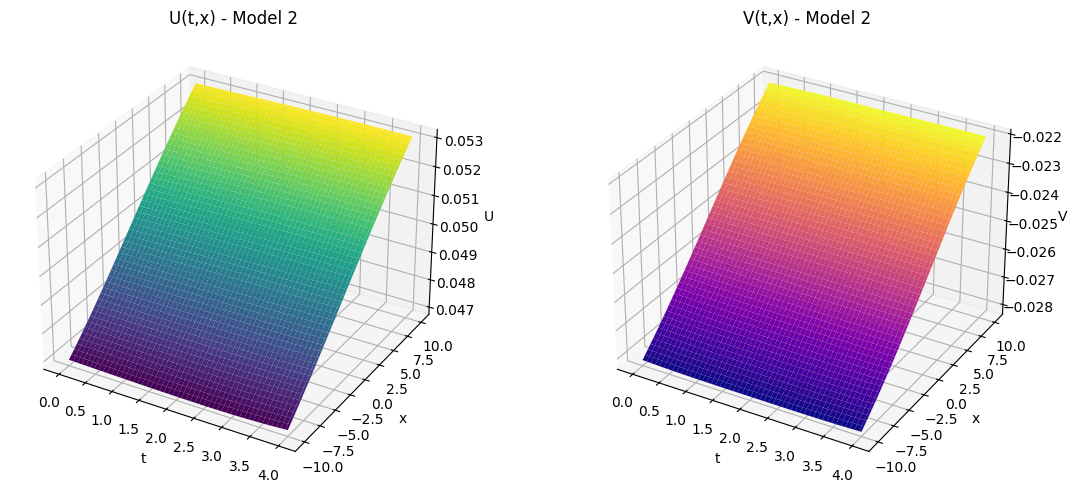

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Device and dtype
DTYPE = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Model 2: Problem 2 ---
print("\n--- Model 2: Problem 2 ---")

# Domain bounds
tmin_2, tmax_2 = 0., 4.
xmin_2, xmax_2 = -10., 10.
lb_2 = torch.tensor([tmin_2, xmin_2], dtype=DTYPE, device=device)
ub_2 = torch.tensor([tmax_2, xmax_2], dtype=DTYPE, device=device)

# Exact solution
def exact_solution_u_2(x, t):
    return 0.05 * (1 - torch.tanh(-0.00625 * (x + 2 * 0.00625 * t)))

def exact_solution_v_2(x, t):
    return 0.05 * (-0.5 - torch.tanh(-0.00625 * (x + 2 * 0.00625 * t)))

# Initial conditions
def fun_u_0_2(x):
    return exact_solution_u_2(x, torch.tensor(0.0, dtype=DTYPE, device=device))

def fun_v_0_2(x):
    return exact_solution_v_2(x, torch.tensor(0.0, dtype=DTYPE, device=device))

# Boundary conditions
def fun_u_b_2(t, x):
    return exact_solution_u_2(x, t)

def fun_v_b_2(t, x):
    return exact_solution_v_2(x, t)

# Sample sizes
N_0_2, N_b_2, N_r_2 = 100, 200, 5000

# Initial points
t_0_2 = torch.full((N_0_2, 1), lb_2[0], device=device)
x_0_2 = (ub_2[1] - lb_2[1]) * torch.rand((N_0_2, 1), device=device) + lb_2[1]
X_0_2 = torch.cat([t_0_2, x_0_2], dim=1)
u_0_2 = fun_u_0_2(x_0_2)
v_0_2 = fun_v_0_2(x_0_2)

# Boundary points
t_b_2 = (ub_2[0] - lb_2[0]) * torch.rand((N_b_2, 1), device=device) + lb_2[0]
x_b_left_2 = torch.full((N_b_2 // 2, 1), lb_2[1], device=device)
x_b_right_2 = torch.full((N_b_2 - N_b_2 // 2, 1), ub_2[1], device=device)
x_b_2 = torch.cat([x_b_left_2, x_b_right_2], dim=0)
T_b_2 = t_b_2
X_b_2 = torch.cat([T_b_2, x_b_2], dim=1)
u_b_2 = fun_u_b_2(T_b_2, x_b_2)
v_b_2 = fun_v_b_2(T_b_2, x_b_2)

# Collocation points
t_r_2 = (ub_2[0] - lb_2[0]) * torch.rand((N_r_2, 1), device=device) + lb_2[0]
x_r_2 = (ub_2[1] - lb_2[1]) * torch.rand((N_r_2, 1), device=device) + lb_2[1]
X_r_2 = torch.cat([t_r_2, x_r_2], dim=1)

X_data_2 = [X_0_2, X_b_2]
u_data_2 = [u_0_2, u_b_2]
v_data_2 = [v_0_2, v_b_2]

# Coupled PINN model
class CoupledPINN_2(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=32):
        super(CoupledPINN_2, self).__init__()
        self.scaling = lambda x: 2.0 * (x - lb_2) / (ub_2 - lb_2) - 1.0

        def build_network():
            layers = [nn.Linear(2, num_neurons_per_layer)]
            for _ in range(num_hidden_layers):
                layers += [nn.Tanh(), nn.Linear(num_neurons_per_layer, num_neurons_per_layer)]
            layers += [nn.Linear(num_neurons_per_layer, 1)]
            return nn.Sequential(*layers)

        self.net_u = build_network()
        self.net_v = build_network()

    def forward(self, x):
        x_scaled = self.scaling(x)
        return self.net_u(x_scaled), self.net_v(x_scaled)

# PDE residuals
def compute_residuals_2(model, X_r):
    X_r.requires_grad_(True)
    t = X_r[:, 0:1]
    x = X_r[:, 1:2]

    u, v = model(X_r)

    grads_u = torch.autograd.grad(u, X_r, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    grads_v = torch.autograd.grad(v, X_r, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_t, u_x = grads_u[:, 0:1], grads_u[:, 1:2]
    v_t, v_x = grads_v[:, 0:1], grads_v[:, 1:2]

    u_xx = torch.autograd.grad(u_x, X_r, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    v_xx = torch.autograd.grad(v_x, X_r, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 1:2]

    uv = u * v
    uv_x = torch.autograd.grad(uv, X_r, grad_outputs=torch.ones_like(uv), create_graph=True)[0][:, 1:2]

    r1 = u_t - u_xx - 2 * u * u_x + 0.1 * uv_x
    r2 = v_t - v_xx - 2 * v * v_x + 0.3 * uv_x

    return r1, r2

# Loss function
def compute_loss_2(model, X_r, X_data, u_data, v_data):
    r1, r2 = compute_residuals_2(model, X_r)
    loss_r = torch.mean(r1**2) + torch.mean(r2**2)
    loss_data = torch.tensor(0.0, dtype=DTYPE, device=device)
    for i in range(len(X_data)):
        u_pred, v_pred = model(X_data[i])
        loss_data += torch.mean((u_data[i] - u_pred)**2)
        loss_data += torch.mean((v_data[i] - v_pred)**2)
    return loss_r + loss_data

# Model, optimizer
model_2 = CoupledPINN_2().to(device)
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=5000, gamma=0.1)

# Training
epochs_2 = 5000
loss_history_2 = []

start_time_2 = time()
for epoch in range(epochs_2 + 1):
    optimizer_2.zero_grad()
    loss = compute_loss_2(model_2, X_r_2, X_data_2, u_data_2, v_data_2)
    loss.backward()
    optimizer_2.step()
    scheduler_2.step()
    loss_history_2.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:05d}: Loss = {loss.item():.6e}, LR = {optimizer_2.param_groups[0]['lr']:.3e}")

print("Training time (Model 2):", time() - start_time_2)

# Plot loss history
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(loss_history_2)), loss_history_2, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History (Model 2)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Define grid for plotting
N_plot_2 = 100
t_vals_2 = torch.linspace(tmin_2, tmax_2, N_plot_2, device=device)
x_vals_2 = torch.linspace(xmin_2, xmax_2, N_plot_2, device=device)
T_2, X_2 = torch.meshgrid(t_vals_2, x_vals_2, indexing='ij')
TX_2 = torch.cat([T_2.reshape(-1, 1), X_2.reshape(-1, 1)], dim=1)

# Recompute the prediction safely
with torch.no_grad():
    prediction_2 = model_2(TX_2)
    u_pred_2, v_pred_2 = prediction_2[0], prediction_2[1]
    U_2 = u_pred_2.reshape(N_plot_2, N_plot_2).cpu().numpy()
    V_2 = v_pred_2.reshape(N_plot_2, N_plot_2).cpu().numpy()

T_np_2 = T_2.cpu().numpy()
X_np_2 = X_2.cpu().numpy()

# Plot U and V using surface plots
fig_2 = plt.figure(figsize=(12, 5))
ax1_2 = fig_2.add_subplot(121, projection='3d')
ax1_2.plot_surface(T_np_2, X_np_2, U_2, cmap='viridis')
ax1_2.set_title("U(t,x) - Model 2")
ax1_2.set_xlabel('t')
ax1_2.set_ylabel('x')
ax1_2.set_zlabel('U')

ax2_2 = fig_2.add_subplot(122, projection='3d')
ax2_2.plot_surface(T_np_2, X_np_2, V_2, cmap='plasma')
ax2_2.set_title("V(t,x) - Model 2")
ax2_2.set_xlabel('t')
ax2_2.set_ylabel('x')
ax2_2.set_zlabel('V')

plt.tight_layout()
plt.show()



--- Model 3: Problem 3 ---
Epoch 00000: Loss = 2.856322e+00, LR = 1.000e-03
Epoch 00500: Loss = 2.478964e-03, LR = 1.000e-03
Epoch 01000: Loss = 2.232459e-03, LR = 1.000e-03
Epoch 01500: Loss = 2.145082e-03, LR = 1.000e-03
Epoch 02000: Loss = 2.095350e-03, LR = 1.000e-03
Epoch 02500: Loss = 3.185133e-03, LR = 1.000e-03
Epoch 03000: Loss = 2.477900e-03, LR = 1.000e-03
Epoch 03500: Loss = 2.720773e-03, LR = 1.000e-03
Epoch 04000: Loss = 2.930543e-03, LR = 1.000e-03
Epoch 04500: Loss = 1.745326e-03, LR = 1.000e-03
Epoch 05000: Loss = 2.624761e-03, LR = 1.000e-04
Training time (Model 3): 148.33335089683533


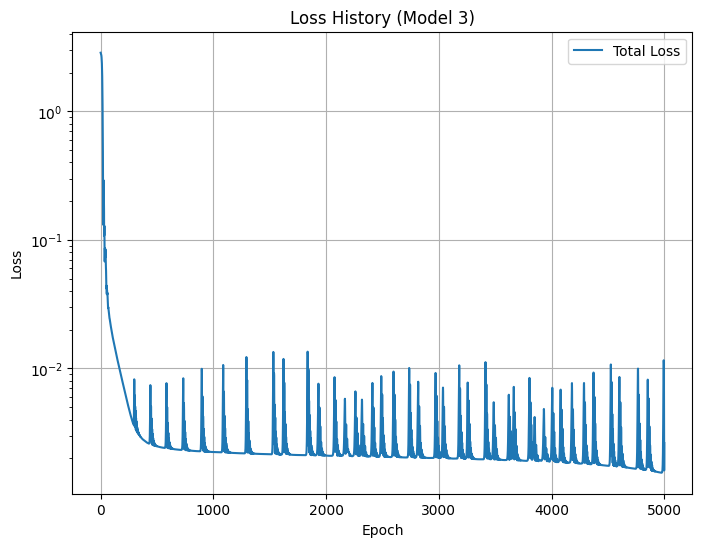

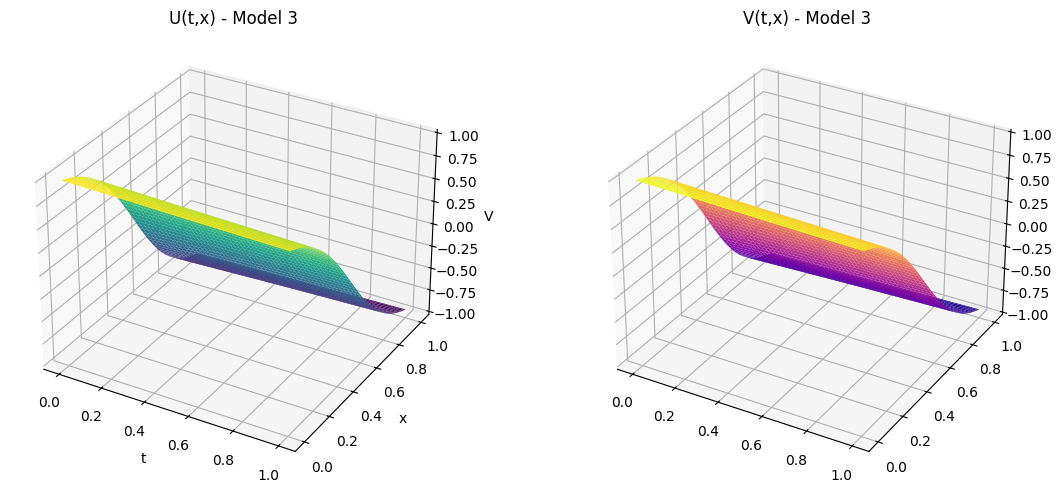

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Device and dtype
DTYPE = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Model 3: Problem 3 ---
print("\n--- Model 3: Problem 3 ---")

# Problem-specific parameter
epsilon_3 = 0.01  # You can change this value

# Domain bounds
tmin_3, tmax_3 = 0., 1.
xmin_3, xmax_3 = 0., 1.
lb_3 = torch.tensor([tmin_3, xmin_3], dtype=DTYPE, device=device)
ub_3 = torch.tensor([tmax_3, xmax_3], dtype=DTYPE, device=device)

# Exact solution
def exact_solution_3(x, t, eps):
    return torch.exp(-eps * np.pi**2 * t) * torch.cos(np.pi * x)

def exact_solution_u_3(x, t):
    return exact_solution_3(x, t, epsilon_3)

def exact_solution_v_3(x, t):
    return exact_solution_3(x, t, epsilon_3)

# Initial conditions
def fun_u_0_3(x):
    return torch.cos(np.pi * x)

def fun_v_0_3(x):
    return torch.cos(np.pi * x)

# Boundary conditions (Dirichlet)
def fun_u_b_3(t, x):
    return exact_solution_u_3(x, t)

def fun_v_b_3(t, x):
    return exact_solution_v_3(x, t)

# Sample sizes
N_0_3, N_b_3, N_r_3 = 100, 200, 5000

# Initial points
t_0_3 = torch.full((N_0_3, 1), lb_3[0], device=device)
x_0_3 = (ub_3[1] - lb_3[1]) * torch.rand((N_0_3, 1), device=device) + lb_3[1]
X_0_3 = torch.cat([t_0_3, x_0_3], dim=1)
u_0_3 = fun_u_0_3(x_0_3)
v_0_3 = fun_v_0_3(x_0_3)

# Boundary points
t_b_3 = (ub_3[0] - lb_3[0]) * torch.rand((N_b_3 // 2, 1), device=device)
x_b_0_3 = torch.zeros((N_b_3 // 2, 1), device=device)
x_b_1_3 = torch.ones((N_b_3 - N_b_3 // 2, 1), device=device)
X_b_0_3 = torch.cat([t_b_3, x_b_0_3], dim=1)
X_b_1_3 = torch.cat([t_b_3[:N_b_3 - N_b_3 // 2], x_b_1_3], dim=1)
X_b_3 = torch.cat([X_b_0_3, X_b_1_3], dim=0)
u_b_3 = fun_u_b_3(X_b_3[:, 0:1], X_b_3[:, 1:2])
v_b_3 = fun_v_b_3(X_b_3[:, 0:1], X_b_3[:, 1:2])

# Collocation points
t_r_3 = (ub_3[0] - lb_3[0]) * torch.rand((N_r_3, 1), device=device) + lb_3[0]
x_r_3 = (ub_3[1] - lb_3[1]) * torch.rand((N_r_3, 1), device=device) + lb_3[1]
X_r_3 = torch.cat([t_r_3, x_r_3], dim=1)

X_data_3 = [X_0_3, X_b_3]
u_data_3 = [u_0_3, u_b_3]
v_data_3 = [v_0_3, v_b_3]

# Coupled PINN model
class CoupledPINN_3(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=32):
        super(CoupledPINN_3, self).__init__()
        self.scaling = lambda x: 2.0 * (x - lb_3) / (ub_3 - lb_3) - 1.0

        def build_network():
            layers = [nn.Linear(2, num_neurons_per_layer)]
            for _ in range(num_hidden_layers):
                layers += [nn.Tanh(), nn.Linear(num_neurons_per_layer, num_neurons_per_layer)]
            layers += [nn.Linear(num_neurons_per_layer, 1)]
            return nn.Sequential(*layers)

        self.net_u = build_network()
        self.net_v = build_network()

    def forward(self, x):
        x_scaled = self.scaling(x)
        return self.net_u(x_scaled), self.net_v(x_scaled)

# PDE residuals
def compute_residuals_3(model, X_r, eps):
    X_r.requires_grad_(True)
    t = X_r[:, 0:1]
    x = X_r[:, 1:2]

    u, v = model(X_r)

    grads_u = torch.autograd.grad(u, X_r, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    grads_v = torch.autograd.grad(v, X_r, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_t, u_x = grads_u[:, 0:1], grads_u[:, 1:2]
    v_t, v_x = grads_v[:, 0:1], grads_v[:, 1:2]

    u_xx = torch.autograd.grad(u_x, X_r, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    v_xx = torch.autograd.grad(v_x, X_r, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 1:2]

    uv = u * v
    uv_x = torch.autograd.grad(uv, X_r, grad_outputs=torch.ones_like(uv), create_graph=True)[0][:, 1:2]

    r1 = u_t - eps * u_xx + 2 * u * u_x - uv_x
    r2 = v_t - eps * v_xx + 2 * v * v_x - uv_x

    return r1, r2

# Loss function
def compute_loss_3(model, X_r, X_data, u_data, v_data, eps):
    r1, r2 = compute_residuals_3(model, X_r, eps)
    loss_r = torch.mean(r1**2) + torch.mean(r2**2)
    loss_data = torch.tensor(0.0, dtype=DTYPE, device=device)
    for i in range(len(X_data)):
        u_pred, v_pred = model(X_data[i])
        loss_data += torch.mean((u_data[i] - u_pred)**2)
        loss_data += torch.mean((v_data[i] - v_pred)**2)
    return loss_r + loss_data

# Model, optimizer
model_3 = CoupledPINN_3().to(device)
optimizer_3 = optim.Adam(model_3.parameters(), lr=1e-3)
scheduler_3 = torch.optim.lr_scheduler.StepLR(optimizer_3, step_size=5000, gamma=0.1)

# Training
epochs_3 = 5000
loss_history_3 = []

start_time_3 = time()
for epoch in range(epochs_3 + 1):
    optimizer_3.zero_grad()
    loss = compute_loss_3(model_3, X_r_3, X_data_3, u_data_3, v_data_3, epsilon_3)
    loss.backward()
    optimizer_3.step()
    scheduler_3.step()
    loss_history_3.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:05d}: Loss = {loss.item():.6e}, LR = {optimizer_3.param_groups[0]['lr']:.3e}")

print("Training time (Model 3):", time() - start_time_3)

# Plot loss history
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(loss_history_3)), loss_history_3, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History (Model 3)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Define grid for plotting
N_plot_3 = 100
t_vals_3 = torch.linspace(tmin_3, tmax_3, N_plot_3, device=device)
x_vals_3 = torch.linspace(xmin_3, xmax_3, N_plot_3, device=device)
T_3, X_3 = torch.meshgrid(t_vals_3, x_vals_3, indexing='ij')
TX_3 = torch.cat([T_3.reshape(-1, 1), X_3.reshape(-1, 1)], dim=1)

# Recompute the prediction safely
with torch.no_grad():
    prediction_3 = model_3(TX_3)
    u_pred_3, v_pred_3 = prediction_3[0], prediction_3[1]
    U_3 = u_pred_3.reshape(N_plot_3, N_plot_3).cpu().numpy()
    V_3 = v_pred_3.reshape(N_plot_3, N_plot_3).cpu().numpy()

T_np_3 = T_3.cpu().numpy()
X_np_3 = X_3.cpu().numpy()

# Plot U and V using surface plots
fig_3 = plt.figure(figsize=(12, 5))
ax1_3 = fig_3.add_subplot(121, projection='3d')
ax1_3.plot_surface(T_np_3, X_np_3, U_3, cmap='viridis')
ax1_3.set_title("U(t,x) - Model 3")
ax1_3.set_xlabel('t')
ax1_3.set_ylabel('x')
ax1_3.set_zlabel('U')

ax2_3 = fig_3.add_subplot(122, projection='3d')
ax2_3.plot_surface(T_np_3, X_np_3, V_3, cmap='plasma')
ax2_3.set_title("V(t,x) - Model 3")
ax1_3.set_xlabel('t')
ax1_3.set_ylabel('x')
ax1_3.set_zlabel('V')

plt.tight_layout()
plt.show()


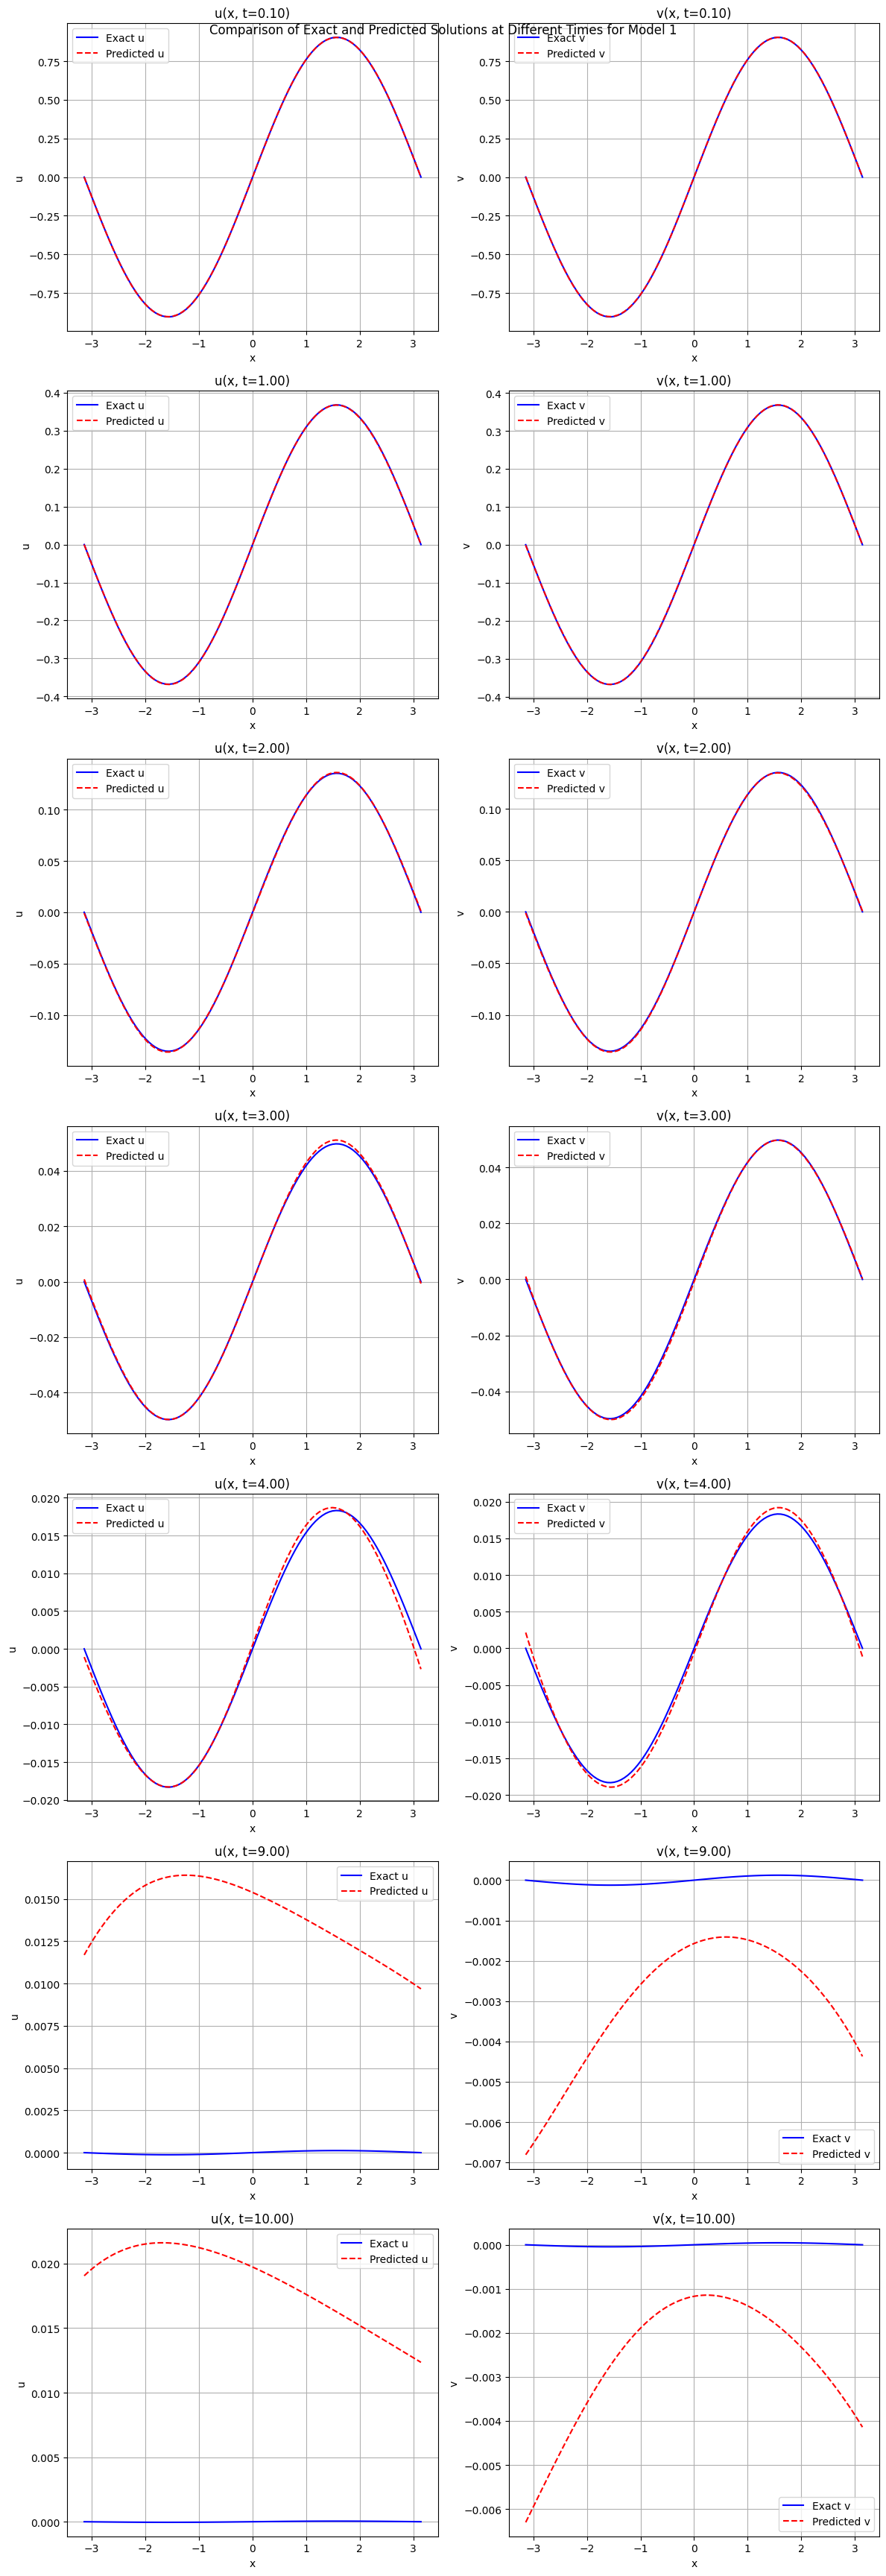

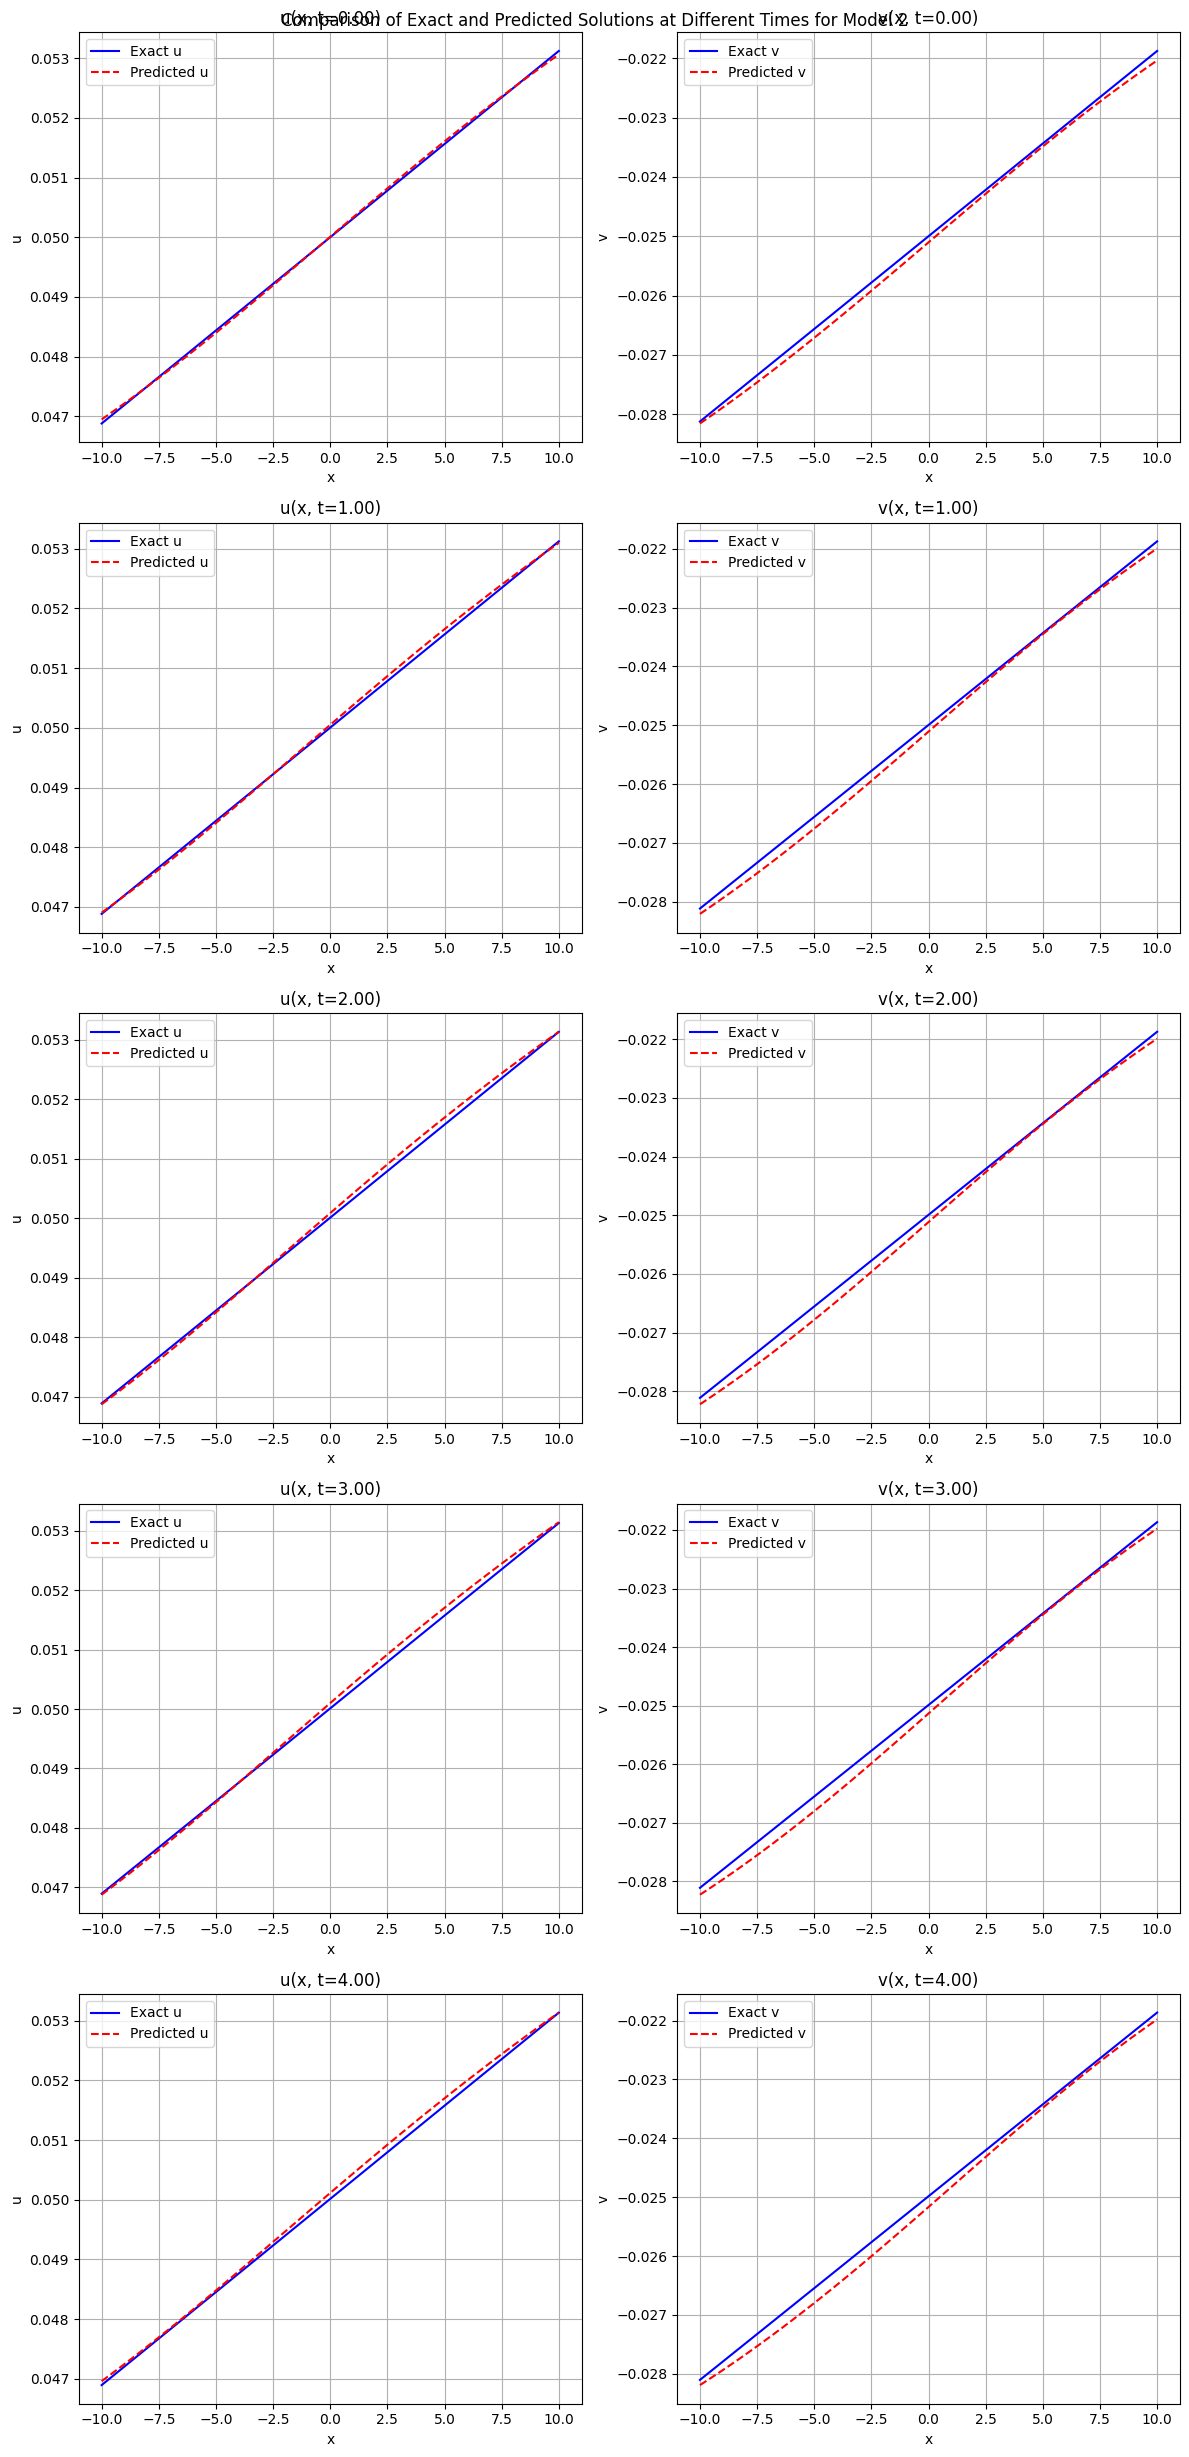

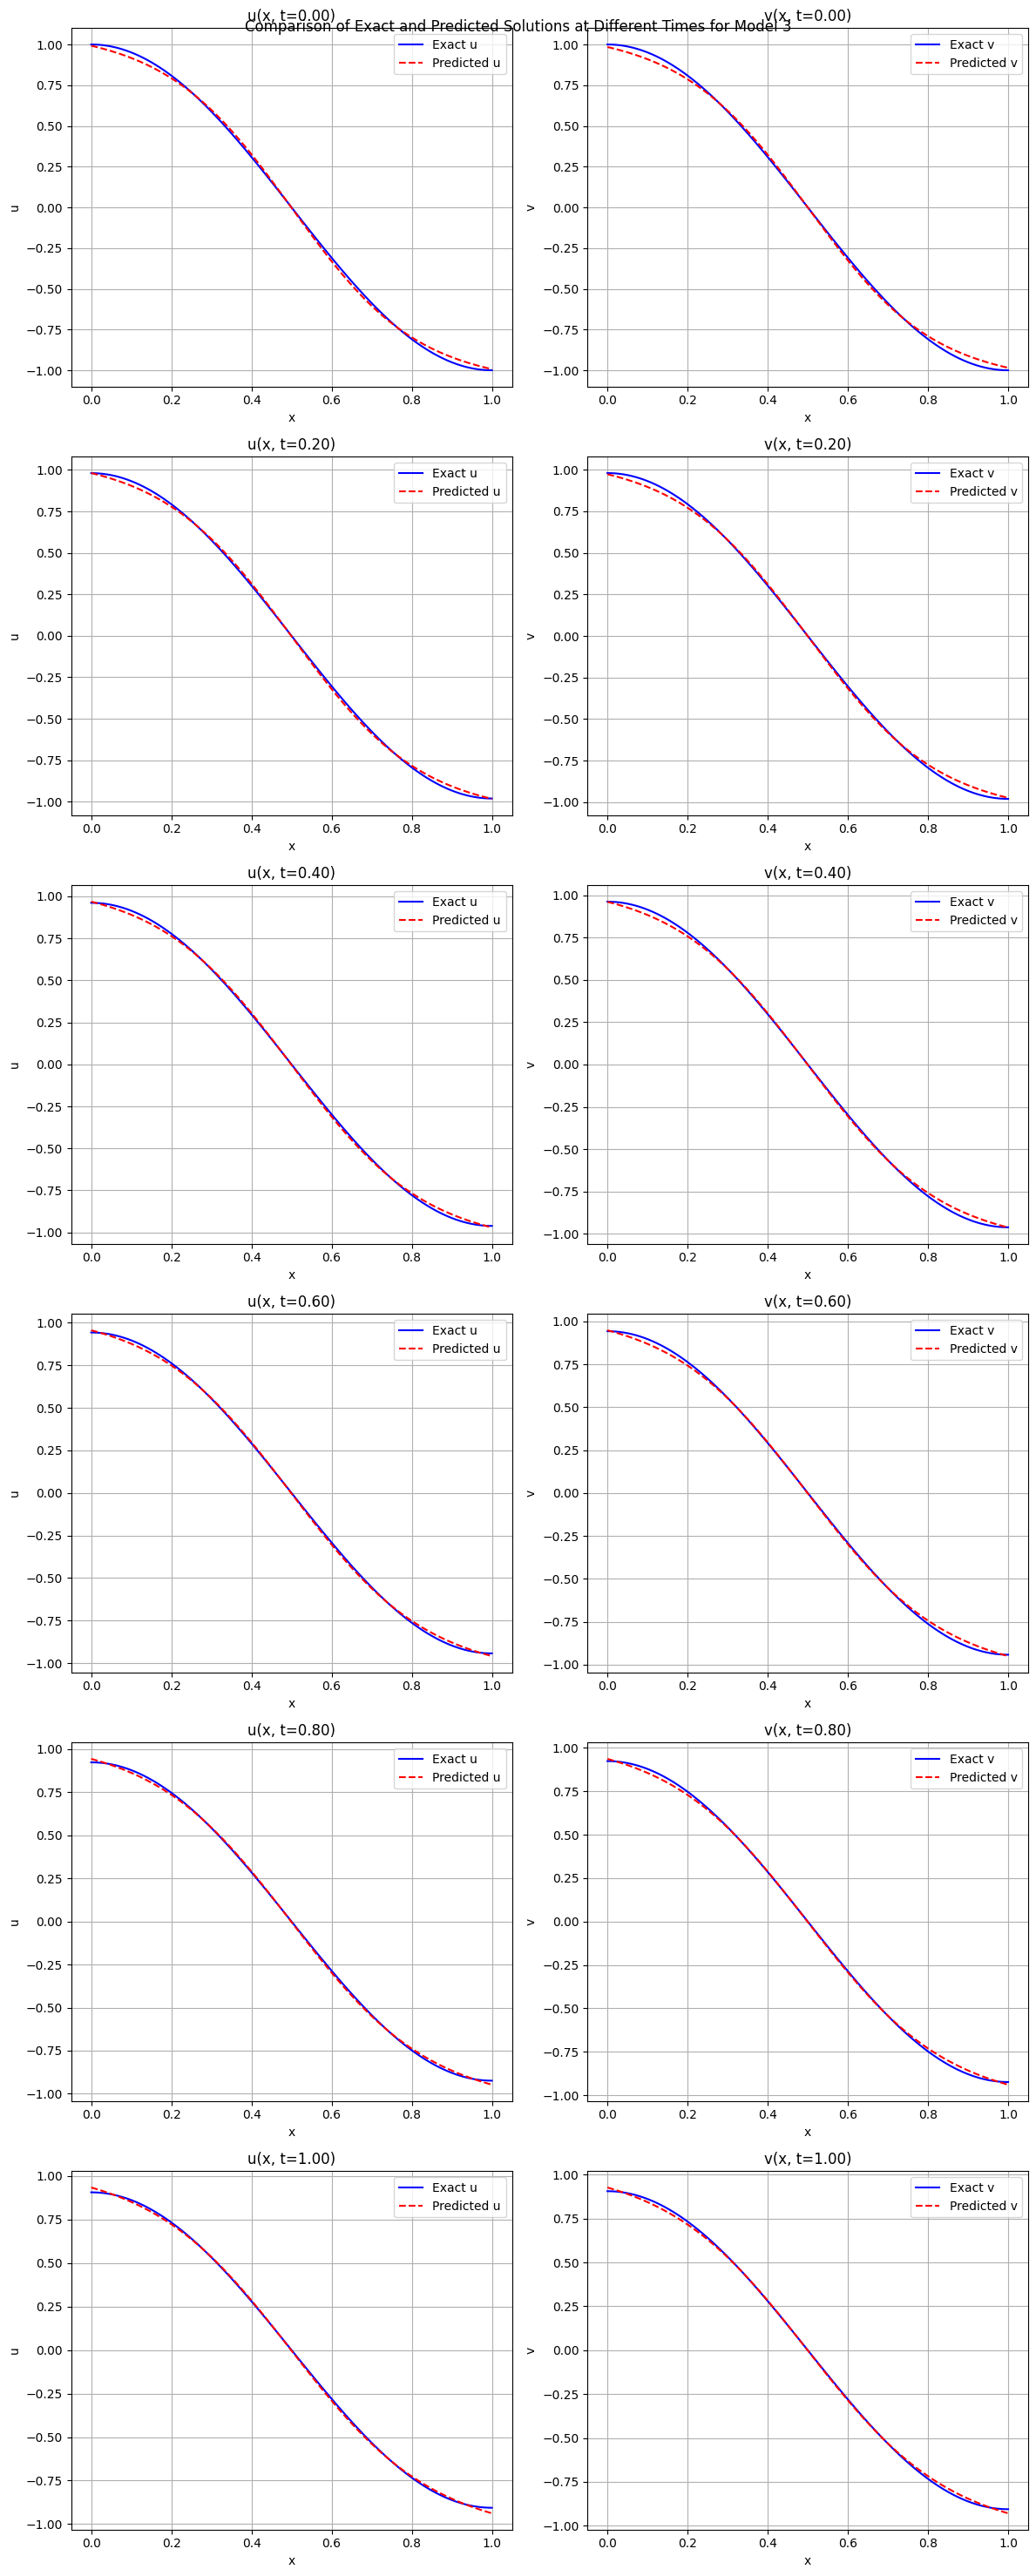

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Device and dtype (Assuming these are already set as in the original code)
DTYPE = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Helper function to compute and plot exact vs predicted ---
def compare_exact_vs_predicted_at_t(model, t_values, x_vals, exact_func_u, exact_func_v, title,suptitle=None):
    """
    Computes and plots the exact and predicted solutions for u and v at given time values.

    Args:
        model (nn.Module): The trained PINN model.
        t_values (list or torch.Tensor): Time values at which to compare the solutions.
        x_vals (torch.Tensor): Space values for plotting.
        exact_func_u (callable): Function to compute the exact solution for u.
        exact_func_v (callable): Function to compute the exact solution for v.
        title (str): Title of the plot.
        suptitle: Overall title
    """
    if not isinstance(t_values, torch.Tensor):
        t_values = torch.tensor(t_values, dtype=DTYPE, device=device)
    num_t = len(t_values)

    fig, axs = plt.subplots(num_t, 2, figsize=(12, 5 * num_t))
    if num_t == 1:
        axs = [axs]  # Ensure axs is iterable even for a single row
    if suptitle is not None:
        fig.suptitle(suptitle)

    for i, t_val in enumerate(t_values):
        t = torch.full_like(x_vals, t_val)
        TX = torch.cat([t.reshape(-1, 1), x_vals.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            u_pred, v_pred = model(TX)
            u_pred_np = u_pred.cpu().numpy()
            v_pred_np = v_pred.cpu().numpy()

        u_exact_np = exact_func_u(x_vals, t).cpu().numpy()
        v_exact_np = exact_func_v(x_vals, t).cpu().numpy()

        # Plot u(x, t)
        axs[i, 0].plot(x_vals.cpu(), u_exact_np, 'b-', label='Exact u')
        axs[i, 0].plot(x_vals.cpu(), u_pred_np, 'r--', label='Predicted u')
        axs[i, 0].set_title(f'u(x, t={t_val:.2f})')
        axs[i, 0].set_xlabel('x')
        axs[i, 0].set_ylabel('u')
        axs[i, 0].legend()
        axs[i, 0].grid(True)

        # Plot v(x, t)
        axs[i, 1].plot(x_vals.cpu(), v_exact_np, 'b-', label='Exact v')
        axs[i, 1].plot(x_vals.cpu(), v_pred_np, 'r--', label='Predicted v')
        axs[i, 1].set_title(f'v(x, t={t_val:.2f})')
        axs[i, 1].set_xlabel('x')
        axs[i, 1].set_ylabel('v')
        axs[i, 1].legend()
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

# --- Model 1: Problem 1 ---
N_plot_1 = 100
x_vals_1 = torch.linspace(xmin_1, xmax_1, N_plot_1, device=device)
t_values_1 = [0.1, 1.0, 2.0, 3.0, 4.0,9,10] #added more t values
def exact_u_1(x, t):
    return torch.exp(-t) * torch.sin(x)

def exact_v_1(x, t):
    return torch.exp(-t) * torch.sin(x)


compare_exact_vs_predicted_at_t(model_1, t_values_1, x_vals_1, exact_u_1, exact_v_1,
                                   title='Model 1: Problem 1',suptitle='Comparison of Exact and Predicted Solutions at Different Times for Model 1')

# --- Model 2: Problem 2 ---
N_plot_2 = 100
x_vals_2 = torch.linspace(xmin_2, xmax_2, N_plot_2, device=device)
t_values_2 = [0.0, 1.0, 2.0, 3.0, 4.0]
def exact_u_2(x, t):
    return 0.05 * (1 - torch.tanh(-0.00625 * (x + 2 * 0.00625 * t)))

def exact_v_2(x, t):
    return 0.05 * (-0.5 - torch.tanh(-0.00625 * (x + 2 * 0.00625 * t)))

compare_exact_vs_predicted_at_t(model_2, t_values_2, x_vals_2, exact_u_2, exact_v_2,
                                   title='Model 2: Problem 2',suptitle='Comparison of Exact and Predicted Solutions at Different Times for Model 2')

# --- Model 3: Problem 3 ---
N_plot_3 = 100
x_vals_3 = torch.linspace(xmin_3, xmax_3, N_plot_3, device=device)
t_values_3 = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
def exact_u_3(x, t):
    return torch.exp(-epsilon_3 * np.pi**2 * t) * torch.cos(np.pi * x)


def exact_v_3(x, t):
    return torch.exp(-epsilon_3 * np.pi**2 * t) * torch.cos(np.pi * x)

compare_exact_vs_predicted_at_t(model_3, t_values_3, x_vals_3, exact_u_3, exact_v_3,
                                   title='Model 3: Problem 3',suptitle='Comparison of Exact and Predicted Solutions at Different Times for Model 3')


In [25]:

# --- Calculate L_inf and L2 error for Model 1 ---
def calculate_errors(model, t_val, x_vals, exact_func_u, exact_func_v):
    """
    Calculates the L_inf and L2 errors for u and v at a given time.

    Args:
        model (nn.Module): The trained PINN model.
        t_val (float): The time value at which to calculate the error.
        x_vals (torch.Tensor): Space values.
        exact_func_u (callable): Function to compute the exact solution for u.
        exact_func_v (callable): Function to compute the exact solution for v.

    Returns:
        tuple: (error_u_linf, error_v_linf, error_u_l2, error_v_l2)
    """
    t = torch.full_like(x_vals, t_val)
    TX = torch.cat([t.reshape(-1, 1), x_vals.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        u_pred, v_pred = model(TX)
        u_pred_np = u_pred.cpu().numpy()
        v_pred_np = v_pred.cpu().numpy()

    u_exact_np = exact_func_u(x_vals, t).cpu().numpy()
    v_exact_np = exact_func_v(x_vals, t).cpu().numpy()

    error_u_linf = np.max(np.abs(u_pred_np - u_exact_np))
    error_v_linf = np.max(np.abs(v_pred_np - v_exact_np))

    error_u_l2 = np.sqrt(np.mean((u_pred_np - u_exact_np) ** 2))
    error_v_l2 = np.sqrt(np.mean((v_pred_np - v_exact_np) ** 2))

    return error_u_linf, error_v_linf, error_u_l2, error_v_l2


# Calculate errors at t = 0.5 and t = 1.0
x_vals_error = torch.linspace(xmin_1, xmax_1, 1000,
                                 device=device)  # Use more points for accuracy
error_u_linf_05, error_v_linf_05, error_u_l2_05, error_v_l2_05 = calculate_errors(model_1, 0.5, x_vals_error, exact_u_1, exact_v_1)
error_u_linf_10, error_v_linf_10, error_u_l2_10, error_v_l2_10 = calculate_errors(model_1, 1.0, x_vals_error, exact_u_1, exact_v_1)

# --- Print the error table ---
print("\nL_inf and L2 errors for Model 1 at t = 0.5 and t = 1.0")
print("-" * 80)
print("{:<10} {:<20} {:<20} {:<20} {:<20}".format("t", "u_Linf", "v_Linf", "u_L2", "v_L2"))
print("-" * 80)
print("{:<10} {:<20.4e} {:<20.4e} {:<20.4e} {:<20.4e}".format(0.5, error_u_linf_05, error_v_linf_05, error_u_l2_05, error_v_l2_05))
print("{:<10} {:<20.4e} {:<20.4e} {:<20.4e} {:<20.4e}".format(1.0, error_u_linf_10, error_v_linf_10, error_u_l2_10, error_v_l2_10))
print("-" * 80)



L_inf and L2 errors for Model 1 at t = 0.5 and t = 1.0
--------------------------------------------------------------------------------
t          u_Linf               v_Linf               u_L2                 v_L2                
--------------------------------------------------------------------------------
0.5        1.2136e+00           1.2135e+00           6.0631e-01           6.0579e-01          
1.0        7.3636e-01           7.3622e-01           3.6758e-01           3.6748e-01          
--------------------------------------------------------------------------------


In [26]:

# --- Calculate L_inf and L2 error for Model 2 ---
def calculate_errors_model2(model, t_val, x_vals, exact_func_u, exact_func_v):
    """
    Calculates the L_inf and L2 errors for u and v at a given time for Model 2.

    Args:
        model (nn.Module): The trained PINN model.
        t_val (float): The time value at which to calculate the error.
        x_vals (torch.Tensor): Space values.
        exact_func_u (callable): Function to compute the exact solution for u.
        exact_func_v (callable): Function to compute the exact solution for v.

    Returns:
        tuple: (error_u_linf, error_v_linf, error_u_l2, error_v_l2)
    """
    t = torch.full_like(x_vals, t_val)
    TX = torch.cat([t.reshape(-1, 1), x_vals.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        u_pred, v_pred = model(TX)
        u_pred_np = u_pred.cpu().numpy()
        v_pred_np = v_pred.cpu().numpy()

    u_exact_np = exact_func_u(x_vals, t).cpu().numpy()
    v_exact_np = exact_func_v(x_vals, t).cpu().numpy()

    error_u_linf = np.max(np.abs(u_pred_np - u_exact_np))
    error_v_linf = np.max(np.abs(v_pred_np - v_exact_np))

    error_u_l2 = np.sqrt(np.mean((u_pred_np - u_exact_np) ** 2))
    error_v_l2 = np.sqrt(np.mean((v_pred_np - v_exact_np) ** 2))

    return error_u_linf, error_v_linf, error_u_l2, error_v_l2



# Calculate errors at t = 0.5, 1.0, 5.0, and 10.0
x_vals_error_2 = torch.linspace(xmin_2, xmax_2, 1000, device=device)  # Use more points
t_values_error_2 = [0.5, 1.0, 5.0, 10.0]
errors_model2 = []
for t_val in t_values_error_2:
    errors_model2.append(calculate_errors_model2(model_2, t_val, x_vals_error_2, exact_u_2, exact_v_2))

# --- Print the error table ---
print("\nL_inf and L2 errors for Model 2 at t = 0.5, 1.0, 5.0, and 10.0")
print("-" * 80)
print("{:<10} {:<20} {:<20} {:<20} {:<20}".format("t", "u_Linf", "v_Linf", "u_L2", "v_L2"))
print("-" * 80)
for i, t_val in enumerate(t_values_error_2):
    error_u_linf, error_v_linf, error_u_l2, error_v_l2 = errors_model2[i]
    print("{:<10} {:<20.4e} {:<20.4e} {:<20.4e} {:<20.4e}".format(t_val, error_u_linf, error_v_linf, error_u_l2, error_v_l2))
print("-" * 80)



L_inf and L2 errors for Model 2 at t = 0.5, 1.0, 5.0, and 10.0
--------------------------------------------------------------------------------
t          u_Linf               v_Linf               u_L2                 v_L2                
--------------------------------------------------------------------------------
0.5        6.2009e-03           6.3115e-03           2.5667e-03           2.5801e-03          
1.0        6.2208e-03           6.3328e-03           2.5743e-03           2.5904e-03          
5.0        6.1998e-03           6.2129e-03           2.5179e-03           2.5472e-03          
10.0       5.7680e-03           4.9985e-03           2.2358e-03           2.1029e-03          
--------------------------------------------------------------------------------


In [27]:
# --- Calculate L_inf and L2 error for Model 3 ---
def calculate_errors_model3(model, t_val, x_vals, exact_func_u, exact_func_v):
    """
    Calculates the L_inf and L2 errors for u and v at a given time for Model 3.

    Args:
        model (nn.Module): The trained PINN model.
        t_val (float): The time value at which to calculate the error.
        x_vals (torch.Tensor): Space values.
        exact_func_u (callable): Function to compute the exact solution for u.
        exact_func_v (callable): Function to compute the exact solution for v.

    Returns:
        tuple: (error_u_linf, error_v_linf, error_u_l2, error_v_l2)
    """
    t = torch.full_like(x_vals, t_val)
    TX = torch.cat([t.reshape(-1, 1), x_vals.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        u_pred, v_pred = model(TX)
        u_pred_np = u_pred.cpu().numpy()
        v_pred_np = v_pred.cpu().numpy()

    u_exact_np = exact_func_u(x_vals, t).cpu().numpy()
    v_exact_np = exact_func_v(x_vals, t).cpu().numpy()

    error_u_linf = np.max(np.abs(u_pred_np - u_exact_np))
    error_v_linf = np.max(np.abs(v_pred_np - v_exact_np))

    error_u_l2 = np.sqrt(np.mean((u_pred_np - u_exact_np) ** 2))
    error_v_l2 = np.sqrt(np.mean((v_pred_np - v_exact_np) ** 2))

    return error_u_linf, error_v_linf, error_u_l2, error_v_l2
# Calculate errors at t = 0.1, 0.3, 0.5, 0.7, and 1.0
x_vals_error_3 = torch.linspace(xmin_3, xmax_3, 1000, device=device)  # Use more points
t_values_error_3 = [0.1, 0.3, 0.5, 0.7, 1.0]
errors_model3 = []
for t_val in t_values_error_3:
    errors_model3.append(calculate_errors_model3(model_3, t_val, x_vals_error_3, exact_u_3, exact_v_3))

# --- Print the error table ---
print("\nL_inf and L2 errors for Model 3 at t = 0.1, 0.3, 0.5, 0.7, and 1.0")
print("-" * 80)
print("{:<10} {:<20} {:<20} {:<20} {:<20}".format("t", "u_Linf", "v_Linf", "u_L2", "v_L2"))
print("-" * 80)
for i, t_val in enumerate(t_values_error_3):
    error_u_linf, error_v_linf, error_u_l2, error_v_l2 = errors_model3[i]
    print("{:<10} {:<20.4e} {:<20.4e} {:<20.4e} {:<20.4e}".format(t_val, error_u_linf, error_v_linf, error_u_l2, error_v_l2))
print("-" * 80)



L_inf and L2 errors for Model 3 at t = 0.1, 0.3, 0.5, 0.7, and 1.0
--------------------------------------------------------------------------------
t          u_Linf               v_Linf               u_L2                 v_L2                
--------------------------------------------------------------------------------
0.1        1.9784e+00           1.9700e+00           9.8436e-01           9.7990e-01          
0.3        1.9475e+00           1.9393e+00           9.6584e-01           9.6137e-01          
0.5        1.9162e+00           1.9082e+00           9.4763e-01           9.4324e-01          
0.7        1.8860e+00           1.8780e+00           9.3047e-01           9.2612e-01          
1.0        1.8438e+00           1.8353e+00           9.0616e-01           9.0174e-01          
--------------------------------------------------------------------------------
